In [21]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
from scipy import integrate
from scipy.special import gammaln
import time
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
%matplotlib inline

In [23]:
import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params

In [3]:
def energies_rs(a,b,gamma,N):
    ''' Returns an array of photon energies with a power law distribution using rejection sampling.
        a = E_min
        b = E_max
        gamma = photon index
        N = total number of photons to be returned
    '''
    start_time = time.time()
    A = (1.-gamma)/((b**(1.-gamma))-(a**(1.-gamma))) #normalization factor so curve integrates to 1
    pl =  lambda x,A,gamma : A*x**(-1.0*gamma)
    binsize = 0.13 #keV, set by Chandra detector. This will be swapped out later for a more realistic binning
    bins = np.arange(a,b,binsize)
    photons = np.zeros(N)
    count = 0
    while count<N:
        r = np.random.uniform(a,b,1)
        for i in range(len(bins)-1):
            if (r>bins[i])and(r<bins[i+1]):
                edge_lo = bins[i]
                edge_hi = bins[i+1]
                p_r = integrate.quad(pl,edge_lo,edge_hi,args=(A,gamma))[0]
                k = np.random.uniform(0,1,1)
                if (k<=p_r):
                    photons[count] = r
                    count += 1
    print("Time to generate photon energies = %s seconds" % (time.time() - start_time))
    return photons

In [7]:
def energies_cdf(a,b,gamma,N):
    '''
    Generate photon energies using the cumulative distribution function (CDF)
    CDF taken from https://arxiv.org/pdf/0706.1062.pdf
    a = E_min
    b = E_max
    gamma = photon index
    N = total number of photons to be returned'''
    start_time = time.time()
    r = np.random.uniform(0,1,N)
    x = a*(1-r)**(-1/(gamma-1))
    print("Time to generate photon energies = %s seconds" % (time.time() - start_time))
    return x

In [135]:
def simulate_data(stop,handle):
    ''' Generates an un-piled and piled list of photon energies. 
        stop = end time of observation, generally equals total length of obs in seconds.
        handle = 'rs' to generate photons via rejection 
    '''
    #Assign physical parameters
    start = 0. #s
    #stop = 100 #s
    cr = 1. #count rate between 0.1 and 10 photons/second
    gamma = 2.7 #assume photon index
    read_time = 3.2 #s
    energy_lo = 0.1 #keV
    energy_hi = 10.0 #keV
    K = (stop-start)*cr #Number of photons to generate
    N = np.random.poisson(K) #choose a number of photons from a poisson distribution centered on expected, K
    print 'number of photons observed =', N
    
    #Assign photon arrival times, random within obervation time
    arrival_times = np.random.uniform(start,stop,N)
    
    #Assign photon energies, random with a power law distribution.
    if handle == 'rs':
        print 'generating photon energies via rejection sampling'
        energy = energies_rs(energy_lo,energy_hi,gamma,N) #generate photon energies using rejection sampling
    if handle == 'cdf':
        print 'generating photon energies via CDF method'
        energy = energies_cdf(energy_lo,energy_hi,gamma,N)
    else:
        print 'invalid photon generation method entered'
        
    #Simulate pile up: bin arrival times, if there is more than one photon in a bin, combine their energies
    #and record as one photon, change other photon energies to 0
    piled_energy = np.copy(energy)
    times = Column(arrival_times,name='time')
    energies = Column(energy,name='energy')
    raw = Table([times,energies])
    raw.sort('time')
    time_bins = np.arange(start,stop,read_time)
    time_hist, time_edges = np.histogram(raw['time'],bins=time_bins)
    num_piled = 0
    for i in range(len(time_hist)):
        if time_hist[i] > 1:
            #print time_hist[i]
            num_piled += time_hist[i]
            first_photon = np.sum(time_hist[0:i])
            last_photon = first_photon + time_hist[i] - 1
            sum_energy = np.sum(energies[first_photon:last_photon])
            piled_energy[first_photon] = sum_energy
            piled_energy[first_photon+1:last_photon] = 0.0
    print 'Fraction of photons that are piled =', np.float(num_piled) / N
    return energy, piled_energy

In [9]:
def plot_data(raw,piled):
    '''
    Takes output data from simulate_data() and plots the raw vs. piled spectra
    '''
    arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
    fig,ax=plt.subplots(figsize=(8,5))
    #num=len(raw)/50.
    e_hist, e_bins = np.histogram(raw,bins=arf['ENERG_HI'])
    pe_hist, pe_bins = np.histogram(piled[piled>0],bins=arf['ENERG_HI'])
    ax.plot(e_bins[1:],e_hist,label='un-piled')
    ax.plot(pe_bins[1:],pe_hist,label='piled')
    ax.set_xlabel('Energy (keV)')
    ax.set_xlim(-0.5,11)
    ax.set_ylabel('Flux, unscaled')
    ax.set_yscale('log')
    ax.legend()
    return e_hist, pe_hist

In [ ]:
#SLOW
#Generate simulated spectrum using rejection sampling method
energy,piled_energy = simulate_data(5000,'rs')
plot_data(energy,piled_energy)

number of photons observed = 499878
generating photon energies via CDF method
Time to generate photon energies = 0.0285758972168 seconds
Fraction of photons that are piled = 0.958651911066


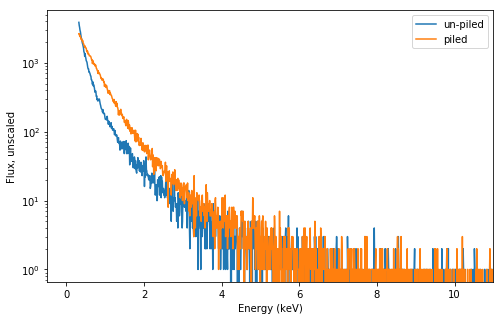

In [138]:
#FAST
#Generate simulated spectrum using CDF method
energy,piled_energy = simulate_data(500000,'cdf')
energy_hist, piled_hist = plot_data(energy,piled_energy)

In [170]:
#Load ARF to get Chandra energy bins
#pi_file = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.pi',format='fits')
#rmf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.rmf',format='fits')
arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
E_min = arf['ENERG_LO']
E_max = arf['ENERG_HI']

In [178]:
e_min = np.arange(0.3,11.0,0.01)
e_max = np.arange(0.31,11.01,0.01)

In [179]:
print e_max

[  0.31   0.32   0.33 ...,  10.98  10.99  11.  ]


In [177]:
E_max

0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41


Meeting notes 03/15/18
1) Write down a Poisson log(likelihood)
2) Write down some log(priors):
    log(A) -> flat (make sure this is in log space to relieve the issue of emphasizing large values)
    alpha -> flat (between 1 and 3)
3) Write down log(posterior distribution)
    Write a function that takes a list of parameters, and calculates the log of 
    P(theta|D) propto P(D|theta)p(theta) -> so if you are in log space, log(posterior) = log(likelihood) + log(priors)
    Parameters are independent: P(alpha, A) = P(alpha)P(A)
    You will find a value for the posterior distribution with a single input alpha, A and then you can iterate through parameter space and make a histogram of posterior vs alpha and posterior vs A to find the most likely value of that paramter
4) MCMC sampling through parameter space
    Read about Metropolis-Hastings
    Write your own sampler
5) Plot P(alpha|D) as a histogram with the real value of alpha superimposed
    p(alpha|D) = integral (P(alpha,A|D)dA)

In [24]:
print len(E_min),len(E_max)

1070 1070


In [18]:
def integrate_lambda(E,A,alpha):
    """ Takes in array of energy bin edges, value of A and alpha and returns finite integral"""
    integral = A/(1-alpha) * np.power(E,1-alpha)
    return integral

In [31]:
def log_likelihood(data,logA,a):
    """
    Return log(Poisson likelihood) function for dataset
    Poisson probability of the form P(k) = exp(-lambda)*lambda**k/k!
    lambda = integral from E_min to E_max A*E**-a
    input data = piled histogram from previous step
    """
    E_min = 
    E_max = 
    lam = integrate_lambda(E_max[1:],np.exp(logA),a) - integrate_lambda(E_min[1:],np.exp(logA),a)
    summation = gammaln(data+1)
    log_like = np.multiply(-1.0,lam) + data*np.log(lam) + summation
    total_log_like = np.sum(log_like)
    if not np.isfinite(total_log_like):
        return -np.inf
    else:
        return total_log_like

In [53]:
def neg_log_likelihood(theta,E_min,E_max):
    """
    Return log(Poisson likelihood) function for dataset
    Poisson probability of the form P(k) = exp(-lambda)*lambda**k/k!
    lambda = integral from E_min to E_max A*E**-a
    input theta = paramtets where theta[0] = logA, theta[1] = alpha
    """
    logA = theta[0]
    a = theta[1]
    lam = integrate_lambda(E_max[1:],np.exp(logA),a) - integrate_lambda(E_min[1:],np.exp(logA),a)
    summation = gammaln(data+1)
    log_like = np.multiply(-1.0,lam) + data*np.log(lam) + summation
    total_log_like = np.sum(log_like)
    if not np.isfinite(total_log_like):
        return -np.inf
    else:
        return -1*total_log_like

In [14]:
def log_prior_alpha(a):
    if (a > 0) and (a<5):
        return np.log(0.2)
    else:
        return -np.inf
def log_prior_logA(logA):
    if (logA<np.log(1000000))and(logA>np.log(100)):
        return np.log(1.0/(np.log(1000000)-np.log(100)))
    else:
        return -np.inf

In [15]:
def log_posterior(log_like,log_priors):
    return log_like + np.sum(log_priors)

In [141]:
#Run brute force likelihood maximization on a grid to test that functions work
A = np.linspace(0,1000000,100)
a = np.linspace(0,5,100)
ll_val = np.zeros((len(A),len(a)),dtype=float)
max_ll = 0
best = [0,0]
count = 0
for i in range(len(A)):
    for j in range(len(a)):
        running_ll = log_likelihood(energy_hist,np.log(A[i]),a[j])
        ll_val[i][j] = running_ll
        count += 1
        if count%len(A) == 0:
            print 'working on round ',count
        if running_ll > max_ll:
            max_ll = running_ll
            best = [i,j]
print 'best fit for values of A=',A[best[0]],a[best[1]], 'log(likelihood)=',max_ll

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


working on round  100
working on round  200
working on round  300
working on round  400
working on round  500
working on round  600
working on round  700
working on round  800
working on round  900
working on round  1000
working on round  1100
working on round  1200
working on round  1300
working on round  1400
working on round  1500
working on round  1600
working on round  1700
working on round  1800
working on round  1900
working on round  2000
working on round  2100
working on round  2200
working on round  2300
working on round  2400
working on round  2500
working on round  2600
working on round  2700
working on round  2800
working on round  2900
working on round  3000
working on round  3100
working on round  3200
working on round  3300
working on round  3400
working on round  3500
working on round  3600
working on round  3700
working on round  3800
working on round  3900
working on round  4000
working on round  4100
working on round  4200
working on round  4300
working on round  44

In [142]:
ll_val[np.isfinite(ll_val)==False] = 0

-25763965.8396 836556.690833


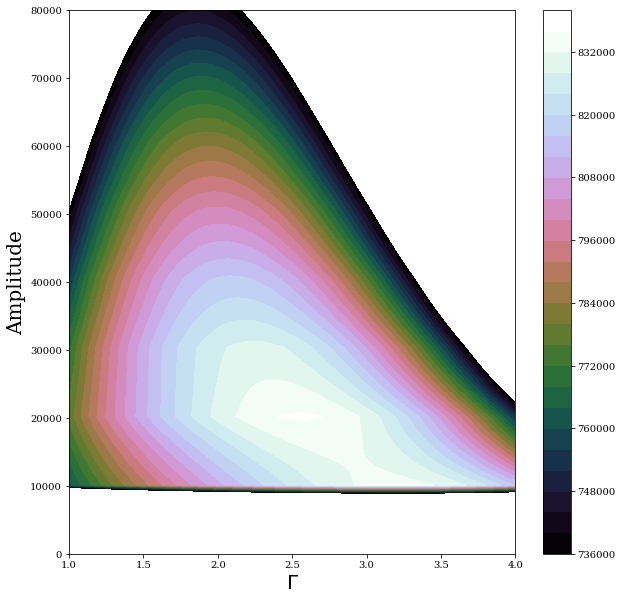

In [169]:
#Plot heat map of log_likelihood values across logA and alpha space
#import seaborn as sns
plt.rc('font', family='serif')
fig,ax=plt.subplots(figsize=(10,10))
print np.amin(ll_val),np.amax(ll_val)
#imgplot = ax.imshow(ll_val[1:,:])
#imgplot.set_cmap('inferno')
#plt.colorbar(imgplot)
#cmap = sns.cubehelix_palette(light=1, as_cmap=True)
#ax = sns.heatmap(ll_val[1:,:],cmap=cmap)
#ax.set_xlabel('A',fontsize=18)
#ax.set_ylabel(r'$\Gamma$',fontsize=18)

#plt.pcolormesh(ll_val)
#plt.colorbar()
#curves = 10
#m = max([max(row) for row in ll_val])
#levels = np.arange(0, m, (1 / float(curves)) * m)
#plt.contour(ll_val, colors="white", levels=levels)
#plt.show()

levels = MaxNLocator(nbins=30).tick_values(np.amax(ll_val)-100000, np.amax(ll_val))
#cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
cf = plt.contourf(a, A, ll_val,cmap='cubehelix',vmin=np.amax(ll_val)-100000,vmax=np.amax(ll_val),levels=levels)
#plt.contour(cf, colors='white',levels=levels,linestyle='--')
fig.colorbar(cf)
ax.set_xlim(1,4)
ax.set_ylim(0,80000)
ax.set_xlabel(r'$\Gamma$',fontsize=20)
ax.set_ylabel('Amplitude',fontsize=20)
#plt.pcolormesh(ll_val)
#plt.colorbar(cs)

In [139]:
#Use scipy.optimize to find the best A and alpha parameters
from scipy.optimize import minimize
data = energy_hist
#logA = np.log(np.linspace(0,1000000,1000))
#a = np.linspace(0,5,1000)
init_params = [np.log(1000000),2.7]
opt = minimize(neg_log_likelihood,init_params,method='Nelder-Mead',options={'disp': True})
print opt.x

Optimization terminated successfully.
         Current function value: -837167.971942
         Iterations: 60
         Function evaluations: 128
[ 9.73550089  2.70422215]
